In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numpy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/1016_vtx.root'))

## Define label
`label` = `signB` * `signVtx` > 0
* same sign of B and vtx -> label = 1
* opposite sign of B and vtx -> label = 0

In [5]:
event_id_column = 'event_id'
data[event_id_column] = data.runNum.apply(str) + '_' + (data.evtNum.apply(int)).apply(str)
# reconstructing sign of B
data['signB'] = data.tagAnswer * (2 * data.iscorrect - 1)
# assure sign is +1 or -1
data['signVtx'] = (data.signVtx.values > 0) * 2 - 1
data['label'] = (data.signVtx.values * data.signB.values > 0) * 1

In [6]:
data.head()

,iscorrect,tagAnswer,signVtx,tagger,evtNum,runNum,nnkrec,mult,ptB,etaB,...,svp,om_muon,om_ele,om_kaon,om_same,om_vtx,N_sig_sw,event_id,signB,label
0,0,1,-1,0,490856995,115839,3,19,-0.382002,-6.307031,...,5.458805,0,0,0,0,0,1.034008,115839_490856995,-1,1
1,1,1,-1,0,822264706,115839,2,10,2.117417,-2.673835,...,3.035841,0,0,0,0,0,1.091844,115839_822264706,1,0
2,1,1,-1,0,68238381,115839,4,16,0.788837,-4.426422,...,4.479315,0,0,0,0,0,-0.263734,115839_68238381,1,0
3,1,1,-1,0,3537659,115839,3,38,0.070327,-4.690033,...,4.092348,0,0,0,0,0,1.062726,115839_3537659,1,0
4,0,1,-1,0,2079583,115839,2,31,1.172778,-3.726187,...,2.617929,0,0,0,0,0,0.949457,115839_2079583,-1,1


In [7]:
get_events_statistics(data)

{'Events': 427102, 'tracks': 427103}

In [8]:
N_pass = get_events_number(data)
tagging_efficiency = 1. * N_pass / get_N_B_events()
tagging_efficiency_delta = sqrt(N_pass) / get_N_B_events()
print tagging_efficiency, tagging_efficiency_delta

0.397426963471 0.000731430257878


### Define B-like events for training and others for prediction

In [9]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 247173, 'tracks': 247173}

### Define features

In [10]:
features =  ['mult', 'nnkrec', 'ptB', 'vflag', 'ipsmean', 'ptmean', 'vcharge', 
             'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']

## Find good vtx to define sign B

trying to guess sign of B based on sign of vtx. If the guess is good, the vtx will be used on next step to train classifier.

### 2-folding random forest selection for right tagged events

In [11]:
data_sw_passed_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw)

In [12]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=50, n_jobs=4)
est_choose_RT = FoldingClassifier(base, features=features, random_state=13)
%time est_choose_RT.fit_lds(data_sw_passed_lds)
pass

CPU times: user 2min 12s, sys: 2.09 s, total: 2min 14s
Wall time: 34.7 s


In [13]:
report = ClassificationReport({'rf': est_choose_RT}, data_sw_passed_lds)

KFold prediction using folds column


### ROC AUC

In [14]:
report.compute_metric(RocAuc())

OrderedDict([('rf', 0.55305902958521591)])

### ROC curve

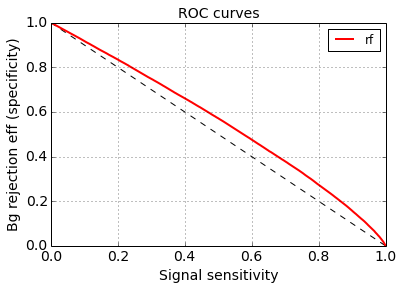

In [15]:
plot([0, 1], [1, 0], 'k--')
report.roc()

In [16]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
imp = pandas.DataFrame({'importance': imp, 'feature': est_choose_RT.features})
imp.sort('importance', ascending=False)

,feature,importance
5,ptmean,0.428948
4,ipsmean,0.261835
7,svm,0.239577
6,vcharge,0.204398
9,BDphiDir,0.160545
10,svtau,0.146701
8,svp,0.144029
0,mult,0.127766
2,ptB,0.118018
11,docamax,0.094645


## Distributions of output
Using flattening of output with respect to one of classes

In [17]:
from utils import plot_flattened_probs

KFold prediction using folds column


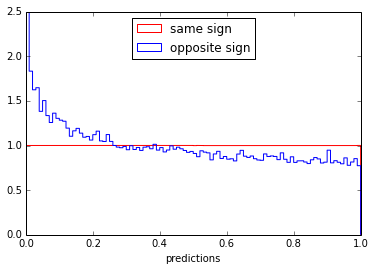

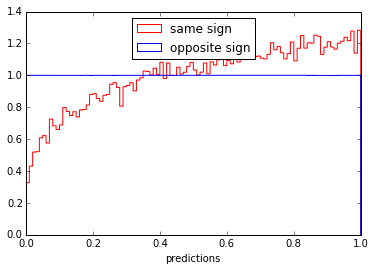

In [18]:
probs = est_choose_RT.predict_proba(data_sw_passed)
flat_ss = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=1)
flat_os = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=0)

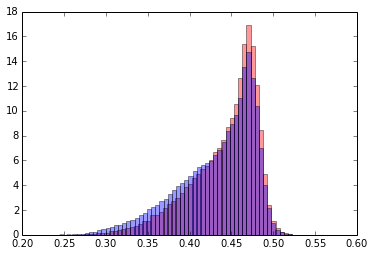

In [19]:
hist(probs[data_sw_passed.label.values == 1][:, 1], bins=60, normed=True, alpha=0.4)
hist(probs[data_sw_passed.label.values == 0][:, 1], bins=60, normed=True, alpha=0.4)
pass

## Select good vtx

leaving for training only those events that were not-so poorly predicted by RandomForest.

In [20]:
mask = ((flat_ss(probs[:, 1]) < 0.6) & (data_sw_passed.label == 0)) | \
       ((flat_os(probs[:, 1]) > 0.2) & (data_sw_passed.label == 1))
data_sw_passed_selected = data_sw_passed[mask]
data_sw_passed_not_selected = data_sw_passed[~mask]

In [21]:
get_events_statistics(data_sw_passed_selected)

{'Events': 185460, 'tracks': 185460}

In [22]:
data_sw_passed_selected_lds = LabeledDataStorage(data_sw_passed_selected, 
                                                 data_sw_passed_selected.label, 
                                                 data_sw_passed_selected.N_sig_sw)

### DT for good vtx

In [23]:
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=9000, depth=6, pretransform_needed=True, 
                                  max_features=8, loss=LogLossFunction(regularization=100))
tt_folding_rf = FoldingClassifier(tt_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                                   features=features)
%time tt_folding_rf.fit_lds(data_sw_passed_selected_lds)
pass

CPU times: user 24.8 s, sys: 2.16 s, total: 26.9 s
Wall time: 3min 49s


### Report for selected vtx

In [24]:
report = ClassificationReport({'tt': tt_folding_rf}, data_sw_passed_selected_lds)

KFold prediction using folds column


Default prediction


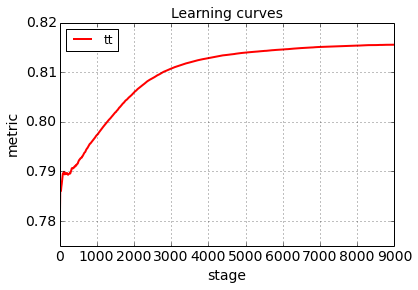

In [25]:
report.learning_curve(RocAuc())

In [26]:
report.compute_metric(RocAuc())

OrderedDict([('tt', 0.81554209347063)])

-----------

## Training on all vtx
in this case we don't use preselection with RandomForest

### DT full

In [27]:
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=1500, depth=6, pretransform_needed=True, 
                                  max_features=8, loss=LogLossFunction(regularization=100))
tt_folding = FoldingClassifier(tt_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                               features=features)
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 5.93 s, sys: 520 ms, total: 6.45 s
Wall time: 51.3 s


### Report for all vtx

In [28]:
report = ClassificationReport({'tt': tt_folding}, data_sw_passed_lds)

KFold prediction using folds column


Default prediction


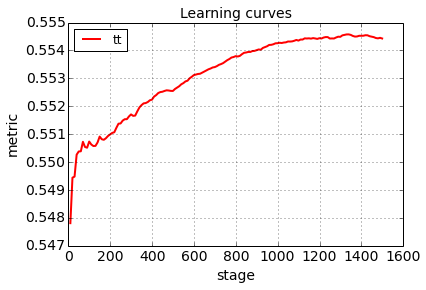

In [29]:
report.learning_curve(RocAuc())

In [30]:
report.compute_metric(RocAuc())

OrderedDict([('tt', 0.5544309400521632)])

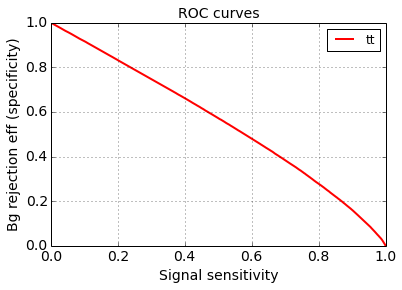

In [31]:
report.roc()

--------

## Calibrating results $p(\text{vrt same sign}|B)$ and combining them

In [34]:
models = []

In [35]:
from utils import get_result_with_bootstrap_for_given_part

KFold prediction using folds column
KFold prediction using folds column


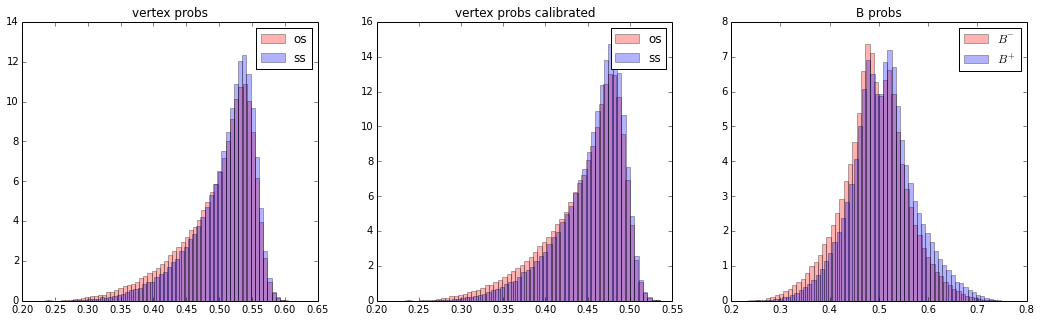

AUC for tagged: 0.594531402965 AUC with untag: 0.545941336892
mean AUC after calibration: 0.594617024804 1.39432754719e-06


In [36]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 
                                                      logistic=True, name="tt-log",
                                                      sign_part_column='signVtx', part_name='vertex'))

KFold prediction using folds column
KFold prediction using folds column


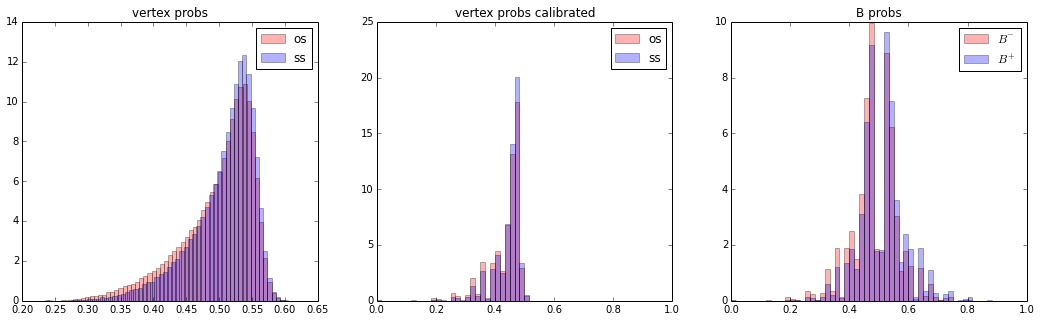

AUC for tagged: 0.594426504272 AUC with untag: 0.546503619328
mean AUC after calibration: 0.594335879589 8.77876636993e-07


In [37]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 
                                                      logistic=False, name="tt-iso",
                                                      sign_part_column='signVtx', part_name='vertex'))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


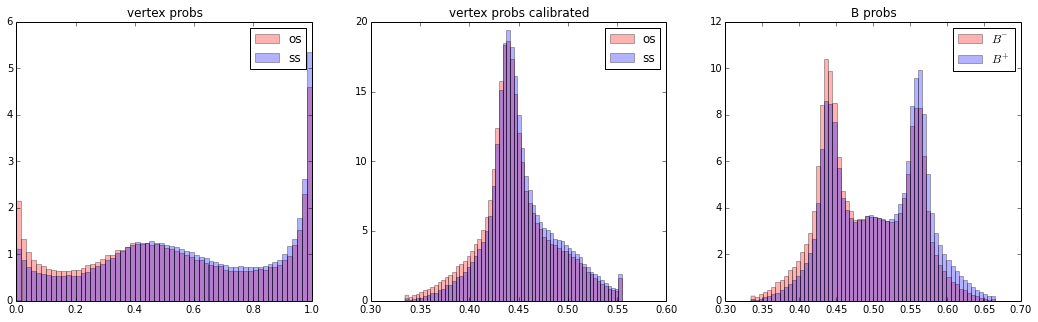

AUC for tagged: 0.594876938573 AUC with untag: 0.545332191596
mean AUC after calibration: 0.594915538591 1.91431386544e-06


In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding_rf, 
                                                      [data_sw_passed_selected,
                                                       data_sw_passed_not_selected,
                                                       data_sw_not_passed],
                                                      logistic=True, name="rf-tt-log",
                                                      sign_part_column='signVtx', part_name='vertex'))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


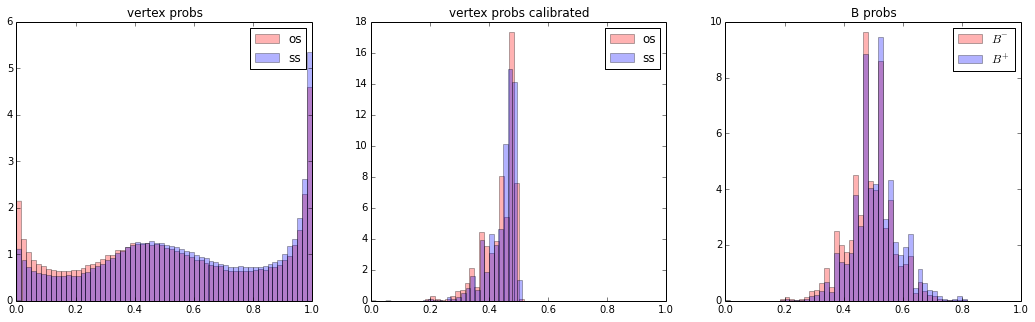

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency,
                                                       tagging_efficiency_delta, tt_folding_rf, 
                                                      [data_sw_passed_selected,
                                                       data_sw_passed_not_selected, 
                                                       data_sw_not_passed], 
                                                      logistic=False, name="rf-tt-iso",
                                                      sign_part_column='signVtx', part_name='vertex'))

# Comparison of different models

In [41]:
pandas.concat(models)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,39.742696,0.073143,0.027520,0.000569,1.093730,0.022685,54.594134,0
0,tt-iso,39.742696,0.073143,0.031223,0.003030,1.240869,0.120423,54.650362,0
0,rf-tt-log,39.742696,0.073143,0.027696,0.000673,1.100699,0.026814,54.533219,0
0,rf-tt-iso,39.742696,0.073143,0.028914,0.003222,1.149137,0.128051,54.678429,0


## Implementing the best vertex model

and saving its predictions

In [42]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column
KFold prediction using folds column


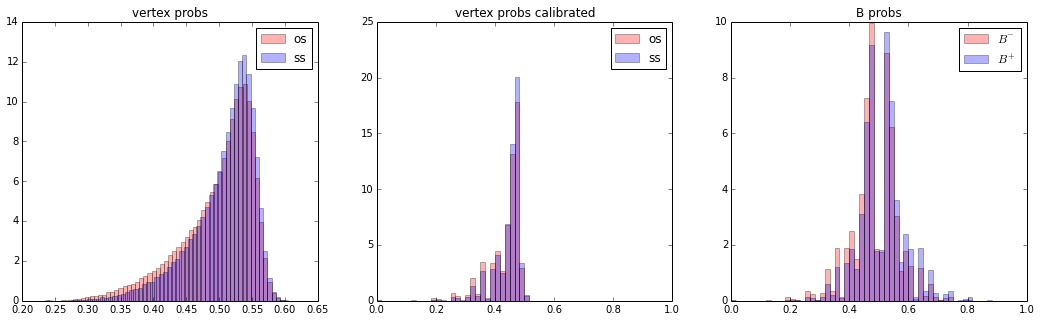

AUC for tagged: 0.594426504272 AUC with untag: 0.546503619328


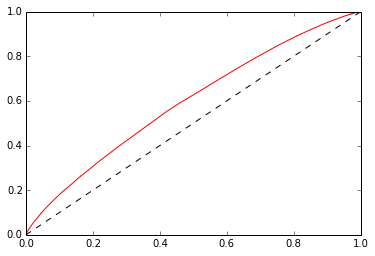

In [43]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data_sw_passed, data_sw_not_passed], logistic=False,
                                               sign_part_column='signVtx', part_name='vertex')

In [44]:
Bdata_prepared.to_csv('models/Bdata_vertex.csv', header=True, index=False)